In [1]:
import numpy as np
import os
from random import shuffle
import re

In [2]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

### Load dataset

In [3]:
import urllib.request
import zipfile
import lxml.etree

In [65]:
# For now, we're only interested in the subtitle text, so let's extract that from the XML:
with zipfile.ZipFile('c:/Users/kun/NLP/oxford-cs-deepnlp-2017/practical1/ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
input_text = doc.xpath('//content/text()')
input_keywords = doc.xpath('//keywords/text()')
#input_text_string = '\n'.join(input_text)
del doc

In [61]:
print(len(input_text))
print(len(input_keywords))

2085
2085


In [66]:
train_text = input_text[:1585]
valid_text = input_text[1585:1835]
test_text = input_text[1835:]

train_keywords = input_keywords[:1585]
valid_keywords = input_keywords[1585:1835]
test_keywords = input_keywords[1835:]

del input_text

print(len(train_text), len(train_keywords))
print(len(valid_text), len(valid_keywords))
print(len(test_text), len(test_keywords))

1585 1585
250 250
250 250


In [81]:
labels = ['technology', 'design', 'entertainment']

def build_pairs(text, keywords):
    '''
    text: input text, list of string
    keywords: input keywords that responding to input text, list of string
    return a dictionary mapping text to labels
    '''
    assert len(text) == len(keywords)
    n = len(text)
    pairs = {}
    for i in range(n):
        text_i = text[i]
        valid_keyword = []
        for keyword in keywords[i].lower().split():
            if keyword in labels:
                valid_keyword.append(keyword)
        
        if len(valid_keyword) == 3:
            pairs[text_i] = 'TED'
        elif len(valid_keyword) == 2:
            if 'technology' in valid_keyword:
                if 'design' in valid_keyword:
                    pairs[text_i] = 'ToD'
                elif 'entertainment' in valid_keyword:
                    pairs[text_i] = 'TEo'
            else:
                pairs[text_i] = 'oED'
        elif len(valid_keyword) == 1:
            if 'technology' in valid_keyword:
                pairs[text_i] = 'Too'
            elif 'design' in valid_keyword:
                pairs[text_i] = 'ooD'
            else:
                pairs[text_i] = 'oEo'
        else:
            pairs[text_i] = 'ooo'
    
    return pairs
    

In [82]:
train_pairs = build_pairs(train_text, train_keywords)
valid_pairs = build_pairs(valid_text, valid_keywords)
test_pairs = build_pairs(test_text, test_keywords)

In [84]:
for i, j in train_pairs.items():
    print(i, j)
    break

Here are two reasons companies fail: they only do more of the same, or they only do what's new.
To me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation. Both are necessary, but it can be too much of a good thing.
Consider Facit. I'm actually old enough to remember them. Facit was a fantastic company. They were born deep in the Swedish forest, and they made the best mechanical calculators in the world. Everybody used them. And what did Facit do when the electronic calculator came along? They continued doing exactly the same. In six months, they went from maximum revenue ... and they were gone. Gone.
To me, the irony about the Facit story is hearing about the Facit engineers, who had bought cheap, small electronic calculators in Japan that they used to double-check their calculators.
(Laughter)
Facit did too much exploitation. But exploration can go wild, too.
A few years back, I worked closely alongside a European 

### Preprocessing

Let's start by removing all parenthesized strings using a regex:

In [88]:
def preprocessing(pairs):
    new_pairs = {}
    for text, label in pairs.items():
        text_noparens = re.sub(r'\([^)]*\)', '', text)
        tokens = re.sub(r"[^a-z0-9]+", " ", text_noparens.lower()).split()
        new_pairs[tuple(tokens)] = label
    return new_pairs

In [91]:
train_pairs_ = preprocessing(train_pairs)
valid_pairs_ = preprocessing(valid_pairs)
test_pairs_ = preprocessing(test_pairs)

In [90]:
for i, j in train_pairs_.items():
    print(i, j)
    break

('here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new', 'to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation', 'both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing', 'consider', 'facit', 'i', 'm', 'actually', 'old', 'enough', 'to', 'remember', 'them', 'facit', 'was', 'a', 'fantastic', 'company', 'they', 'were', 'born', 'deep', 'in', 'the', 'swedish', 'forest', 'and', 'they', 'made', 'the', 'best', 'mechanical', 'calculators', 'in', 'the', 'world', 'everybody', 'used', 'them', 'and', 'what', 'did', 'facit', 'do', 'when', 'the', 'electronic', 'calculator', 'came', 'along', 'they', 'continued', 'doing', 'exactly', 'the', 'same', 'in', 'six', 'months', 'they', 'went', 'from', 'maximum', 'revenue', 'and', 'they', 'were', 'g

### Build Vocabulary 

In [94]:
train_text_string = '\n'.join(train_text)
valid_text_string = '\n'.join(valid_text)

train_text_noparens = re.sub(r'\([^)]*\)', '', train_text_string)
valid_text_noparens = re.sub(r'\([^)]*\)', '', valid_text_string)

In [95]:
train_text_noparens[:20]

'Here are two reasons'

Now, let's attempt to remove speakers' names that occur at the beginning of a line, by deleting pieces of the form "up to 20 characters:", as shown in this example. Of course, this is an imperfect heuristic.

In [97]:
train_sentences_strings_ted = []
valid_sentences_strings_ted = []

for line in train_text_noparens.split('\n'):
    m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
    train_sentences_strings_ted.extend(sent for sent in m.groupdict()['postcolon'].split('.') if sent)

for line in valid_text_noparens.split('\n'):
    m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
    valid_sentences_strings_ted.extend(sent for sent in m.groupdict()['postcolon'].split('.') if sent)

# Uncomment if you need to save some RAM: these strings are about 50MB.
# del input_text, input_text_noparens

# Let's view the first few:
print(train_sentences_strings_ted[:1])
print(valid_sentences_strings_ted[:1])

["Here are two reasons companies fail: they only do more of the same, or they only do what's new"]
["I'm extremely excited to be given the opportunity to come and speak to you today about what I consider to be the biggest stunt on Earth"]


Now that we have sentences, we're ready to tokenize each of them into words. This tokenization is imperfect, of course. For instance, how many tokens is "can't", and where/how do we split it? We'll take the simplest naive approach of splitting on spaces. Before splitting, we remove non-alphanumeric characters, such as punctuation. You may want to consider the following question: why do we replace these characters with spaces rather than deleting them? Think of a case where this yields a different answer.

In [98]:
train_tokens_ted = []
valid_tokens_ted = []

for sent_str in train_sentences_strings_ted:
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    train_tokens_ted.append(tokens)
    
for sent_str in valid_sentences_strings_ted:
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    valid_tokens_ted.append(tokens)

In [99]:
print('train tokens:', len(train_tokens_ted))
print('valid tokens:', len(valid_tokens_ted))

train tokens: 188306
valid tokens: 38182


In [44]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

train_lems_ted = []
for sen in train_tokens_ted:
    lems_sen = []
    for token in sen:
        lems_sen.append(wordnet_lemmatizer.lemmatize(token))
    train_lems_ted.append(lems_sen)

valid_lems_ted = []
for sen in valid_tokens_ted:
    lems_sen = []
    for token in sen:
        lems_sen.append(wordnet_lemmatizer.lemmatize(token))
    valid_lems_ted.append(lems_sen)

In [102]:
import collections

train_counter = collections.Counter()
for sen in train_tokens_ted:
    train_counter.update(sen)
print('before filtered:', len(train_counter))
    
min_freq = 1
train_filtered = [item for item in train_counter.items() if item[1]>=min_freq]
print('after filtered', len(train_filtered))

filtered_words = [item for item in train_counter.items() if item[1]<min_freq]

train_count_pairs = sorted(train_filtered, key=lambda x:-x[1])
train_words, _ = list(zip(*train_count_pairs))
word_to_id = dict(zip(train_words, range(len(train_words))))


before filtered: 47115
after filtered 47115


In [101]:
word_to_id

{'the': 0,
 'and': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'that': 5,
 'i': 6,
 'in': 7,
 'it': 8,
 'we': 9,
 'you': 10,
 'is': 11,
 's': 12,
 'this': 13,
 'so': 14,
 'they': 15,
 'was': 16,
 'for': 17,
 'are': 18,
 'have': 19,
 'but': 20,
 'what': 21,
 'on': 22,
 'with': 23,
 'can': 24,
 't': 25,
 'about': 26,
 'there': 27,
 'be': 28,
 'as': 29,
 'at': 30,
 'my': 31,
 'not': 32,
 'all': 33,
 'do': 34,
 'one': 35,
 'people': 36,
 're': 37,
 'like': 38,
 'if': 39,
 'from': 40,
 'our': 41,
 'now': 42,
 'or': 43,
 'an': 44,
 'these': 45,
 'he': 46,
 'just': 47,
 'when': 48,
 'because': 49,
 'me': 50,
 'by': 51,
 'very': 52,
 'how': 53,
 'out': 54,
 'them': 55,
 'more': 56,
 'up': 57,
 'had': 58,
 'their': 59,
 'who': 60,
 'were': 61,
 'going': 62,
 'your': 63,
 'see': 64,
 'know': 65,
 'think': 66,
 'would': 67,
 'which': 68,
 'really': 69,
 'us': 70,
 'here': 71,
 've': 72,
 'get': 73,
 'then': 74,
 'time': 75,
 'world': 76,
 'm': 77,
 'some': 78,
 'actually': 79,
 'has': 80,
 'don': 81,
 'wher

words appears in the valid dataset but not in the training dataset, map these words to a special token. 

In [57]:
special_token = '<unkown>'

len_vocab = len(word_to_id)
unkown_words = []

print(len(valid_counter))
for word, _ in valid_counter.items():
    if word not in word_to_id:
        unkown_words.append(word)
print(len(unkown_words))

22583
3823


### Convert word to numeric

In [192]:
labels = {'TED': 0, 'TEo':1, 'ToD':2, 'oED':3, 'Too':4, 'oEo':5, 'ooD':6, 'ooo':7}

def convert_to_num(pairs):
    pairs_int = {}
    for text, label in pairs.items():
        text_int = [word_to_id[word] for word in text if word in word_to_id]
        label_int = np.zeros(8)
        label_int[labels[label]] = 1
        pairs_int[tuple(text_int)] = label_int
    return pairs_int

In [193]:
train_pairs_int = convert_to_num(train_pairs_)
valid_pairs_int = convert_to_num(valid_pairs_)

In [195]:
for i, j in train_pairs_int.items():
    print(i, j)
    break

(71, 18, 100, 830, 512, 1855, 15, 114, 34, 56, 3, 0, 133, 43, 15, 114, 34, 21, 12, 106, 2, 50, 0, 226, 226, 757, 2, 817, 602, 11, 3530, 54, 0, 1856, 198, 100, 2093, 2343, 1, 5215, 351, 18, 1582, 20, 8, 24, 28, 209, 105, 3, 4, 131, 117, 1014, 13767, 6, 77, 79, 206, 286, 2, 338, 55, 13767, 16, 4, 1225, 497, 15, 61, 606, 676, 7, 0, 7201, 1200, 1, 15, 153, 0, 260, 2227, 16357, 7, 0, 76, 447, 197, 55, 1, 21, 123, 13767, 34, 48, 0, 2642, 9880, 201, 543, 15, 3069, 146, 450, 0, 133, 7, 360, 374, 15, 182, 40, 5537, 3715, 1, 15, 61, 640, 640, 2, 50, 0, 4769, 26, 0, 13767, 184, 11, 1440, 26, 0, 13767, 1834, 60, 58, 1518, 2266, 257, 2642, 16357, 7, 1640, 5, 15, 197, 2, 1753, 1506, 59, 16357, 13767, 123, 209, 105, 5215, 20, 2343, 24, 94, 1682, 209, 4, 196, 86, 111, 6, 495, 2728, 4480, 4, 1472, 7857, 497, 130, 12, 228, 55, 20741, 0, 497, 16, 1783, 15, 58, 2279, 5, 3716, 2, 6176, 108, 1808, 616, 1100, 3, 650, 368, 124, 134, 16, 26, 736, 101, 106, 15, 61, 925, 2358, 1, 0, 6964, 16, 48, 9, 114, 73, 8, 

In [210]:
def get_data_label(pairs_int):
    data = []
    labels = np.zeros([len(pairs_int), 8], dtype=np.float32)
    i = 0
    for text, label in pairs_int.items():
        data.append(list(text))
        #labels.append(label)
        labels[i, :] = label
        i += 1
    return data, labels

In [211]:
train_data, train_labels = get_data_label(train_pairs_int)
valid_data, valid_labels = get_data_label(valid_pairs_int)

In [212]:
assert len(train_data) == len(train_labels)
assert len(valid_data) == len(valid_labels)

### Bulid model

In [200]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
import keras.backend as K
import random

random.seed(55)

In [201]:
import vsmlib

def load_glove(word_to_id, emb_size):
    path = 'glove.6B.50d.txt'
    wordvecs = {}
    with open(path, 'r', encoding="utf-8") as file:
        lines = file.readlines()
        for line in lines:
            tokens = line.split(' ')
            vec = np.array(tokens[1:], dtype=np.float32)
            wordvecs[tokens[0]] = vec
    file.close()
        
    word_vecs = {}
    #n_words = len(word_to_id)
    #res = np.zeros([n_words, emb_size], dtype=np.float32)
    n_not_found = 0
    for word, id in word_to_id.items():
        if word in wordvecs:
            #res[id, :] = wordvecs[word]
            word_vecs[id] = wordvecs[word]
        else:
            n_not_found += 1
            #res[id, :] = np.random.normal(0.0, 0.1, emb_size)
            word_vecs[id] = np.random.normal(0.0, 0.1, emb_size)
    print('n words not found in glove word vectors: ' + str(n_not_found))
    
    return word_vecs  

def load_cbow(word_to_id, emb_size):
    path_to_vsm = "word_linear_sg_50d"
    my_vsm = vsmlib.model.load_from_dir(path_to_vsm)
    
    #n_words = len(word_to_id)
    #res = np.zeros([n_words, emb_size], dtype=np.float32)
    word_vecs = {}
    n_not_found = 0
    for word, id in word_to_id.items():
        try:
            #res[id, :] = my_vsm.get_row(word)
            word_vecs[id] = my_vsm.get_row(word)
        except:
            n_not_found += 1
            #res[id, :] = np.random.normal(0.0, 0.1, emb_size)          
            word_vecs[id] = np.random.normal(0.0, 0.1, emb_size)
            # pass                   
    print('n words not found in skip gram word vectors: ' + str(n_not_found))

    return word_vecs

def load_random(word_to_id, emb_size):
    #n_words = len(word_to_id)
    #res = np.zeros([n_words, emb_size], dtype=np.float32)
    word_vecs = {}
    for word, id in word_to_id.items():        
        word_vecs[id] = np.random.normal(0.0, 0.1, emb_size)

    return res

def fill_with_pretrained_embedding(word_to_id, emb_size, tag='random'):       
    if tag == 'glove':
        return load_glove(word_to_id, emb_size)
    elif tag == 'word2vec':
        return load_cbow(word_to_id, emb_size)
    else:
        return load_random(word_to_id, emb_size)
    

In [202]:
res = fill_with_pretrained_embedding(word_to_id, 50, 'word2vec')

n words not found in skip gram word vectors: 2957


In [174]:
for i, j in res.items():
    print(i, j)
    break

0 [-0.095738    0.189961   -0.034146    0.54617798  0.22668301  0.335547
  0.20208301  0.037279   -0.013199   -0.35584199 -0.69640303  0.314886
 -0.065017    0.007158    0.09426    -0.88436699 -0.67106098  0.491606
 -0.62265903  0.027554    0.049129    0.55017298  0.43252     0.013473
  0.070288    0.058233   -0.207626    0.104432    0.041371   -0.13020501
  0.079588   -1.04272997  0.14076    -0.93160999 -0.006122   -0.71364897
  0.674326   -0.164903    0.48833501 -0.37884301  0.126022    0.86592901
 -0.154432    0.619959   -0.148994   -0.56824201  0.66016299 -0.200849
  0.229782    0.023693  ]


In [203]:
def build_doc_embedding(data, word_to_id, emb_size=50, tag='random'):
    '''
    bag-of-mean representation of document.
    '''
    word_embedding = fill_with_pretrained_embedding(word_to_id, emb_size, tag)
    
    doc_embeddings = np.zeros([len(data), emb_size], dtype=np.float32)
    for i in range(len(data)):
        doc = data[i]
        vecs = np.zeros(emb_size, dtype=np.float32)
        count = 0
        for word_id in doc:
            if word_id in word_embedding:
                vecs += word_embedding[word_id]
                count += 1
        doc_embeddings[i, :] = vecs/count
    
    return doc_embeddings
    

In [204]:
train_embeddings = build_doc_embedding(train_data, word_to_id, tag='word2vec')
valid_embeddings = build_doc_embedding(valid_data, word_to_id, tag='word2vec')

n words not found in skip gram word vectors: 2957


E:\software\anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


n words not found in skip gram word vectors: 2957


In [213]:
print(train_embeddings.shape)
print(train_labels.shape)
print(valid_embeddings.shape)
print(valid_labels.shape)

(1580, 50)
(1580, 8)
(250, 50)
(250, 8)


In [245]:
def build_model():
    
    model = Sequential()
    model.add(Dense(100, activation='sigmoid', input_dim=50))    
    #model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(8, activation='softmax'))
    
    adam = optimizers.adam()
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    
    return model

In [246]:
model = build_model()

bst_model_path = "weights.best.hdf5"
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True, verbose=1)
early_stopping =EarlyStopping(monitor='val_loss', patience=3)
    
history = model.fit(train_embeddings, train_labels, epochs=100, batch_size=50,
                   validation_data = (valid_embeddings, valid_labels),
                   callbacks=[early_stopping, model_checkpoint])

Train on 1580 samples, validate on 250 samples
Epoch 1/100
1580/1580 [==============================] - 1s 414us/step - loss: 0.2791 - acc: 0.1494 - val_loss: 1.1921e-07 - val_acc: 0.0000e+00
Epoch 2/100
1580/1580 [==============================] - 0s 86us/step - loss: 1.1921e-07 - acc: 0.0000e+00 - val_loss: 1.1921e-07 - val_acc: 0.0000e+00
Epoch 3/100
1580/1580 [==============================] - 0s 78us/step - loss: 1.1921e-07 - acc: 0.0000e+00 - val_loss: 1.1921e-07 - val_acc: 0.0000e+00
Epoch 4/100
1580/1580 [==============================] - 0s 94us/step - loss: 1.1921e-07 - acc: 0.0000e+00 - val_loss: 1.1921e-07 - val_acc: 0.0000e+00


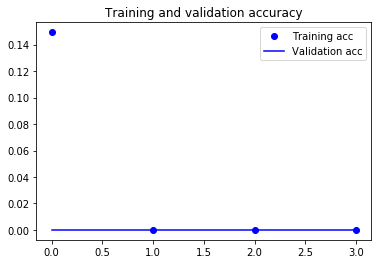

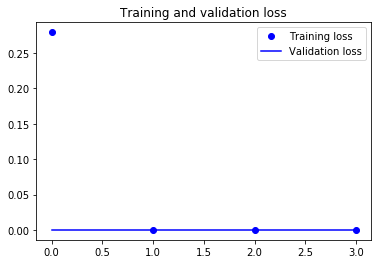

In [247]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [244]:
model.load_weights(filepath=bst_model_path)
score = model.evaluate(valid_embeddings, valid_labels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

250/250 [==============================] - 0s 97us/step
Test loss: 1.19209303762e-07
Test accuracy: 0.0
